# Converting Activity Columns to Binary 
to be used with forecasters that can use categorical in X

In [229]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
from src.data.data_loader import load_data
import pandas as pd

# Load the data with specified columns
df = load_data(use_cached=True)

In [231]:
from src.data.data_cleaner import clean_data

df = clean_data(df)

In [232]:
df.head()

,datetime,id,p_num,time,bg-0:00,insulin-0:00,carbs-0:00,hr-0:00,steps-0:00,cals-0:00,activity-0:00,cob,carb_availability,iob
0,2025-01-01 06:10:00,p01_0,p01,06:10:00,15.1,0.0417,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.402800
1,2025-01-01 06:25:00,p01_1,p01,06:25:00,14.4,0.0417,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.872082
2,2025-01-01 06:40:00,p01_2,p01,06:40:00,13.9,0.0417,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.385682
3,2025-01-01 06:55:00,p01_3,p01,06:55:00,13.8,0.0417,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.838095
4,2025-01-01 07:10:00,p01_4,p01,07:10:00,13.4,0.0417,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.203691


In [233]:
print(df["activity-0:00"].unique())

[nan 'Walk' 'Yoga' 'Swim' 'Outdoor Bike' 'Indoor climbing' 'HIIT'
 'Aerobic Workout' 'Dancing' 'Walking' 'Running' 'Swimming' 'Run' 'Sport'
 'Tennis' 'Workout' 'Strength training' 'Weights' 'Hike' 'Bike']


In [234]:
df = pd.get_dummies(df, columns=["activity-0:00"], dtype=int)

In [235]:
df.head()

,datetime,id,p_num,time,bg-0:00,insulin-0:00,carbs-0:00,hr-0:00,steps-0:00,cals-0:00,...,activity-0:00_Sport,activity-0:00_Strength training,activity-0:00_Swim,activity-0:00_Swimming,activity-0:00_Tennis,activity-0:00_Walk,activity-0:00_Walking,activity-0:00_Weights,activity-0:00_Workout,activity-0:00_Yoga
0,2025-01-01 06:10:00,p01_0,p01,06:10:00,15.1,0.0417,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2025-01-01 06:25:00,p01_1,p01,06:25:00,14.4,0.0417,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2025-01-01 06:40:00,p01_2,p01,06:40:00,13.9,0.0417,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2025-01-01 06:55:00,p01_3,p01,06:55:00,13.8,0.0417,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2025-01-01 07:10:00,p01_4,p01,07:10:00,13.4,0.0417,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [236]:
from sktime.registry import all_estimators

forecasters = all_estimators(
    estimator_types="forecaster",
    filter_tags={"capability:categorical_in_X": True},
    as_dataframe=True,
)

forecasters

,name,object
0,ForecastingPipeline,<class 'sktime.forecasting.compose._pipeline.F...
1,SkforecastAutoreg,<class 'sktime.forecasting.compose._skforecast...
2,SkforecastRecursive,<class 'sktime.forecasting.compose._skforecast...
3,YfromX,<class 'sktime.forecasting.compose._reduce.Yfr...


### Load data for one patient

In [237]:
patient = "p04"

In [238]:
from src.data.kaggle_brisT1D.data_loader import BrisT1DDataLoader

# Split up data into day and night
loader = BrisT1DDataLoader(use_cached=True)

train_df = loader.train_data[loader.train_data["p_num"] == patient]
test_df = loader.validation_data[loader.validation_data["p_num"] == patient]

TIME_STEP_SIZE = (
    train_df["datetime"].iloc[1] - train_df["datetime"].iloc[0]
).components.minutes

if TIME_STEP_SIZE != 5 and TIME_STEP_SIZE != 15:
    error = """
    First time step is not 5 or 15 minutes. Look at the most common time step size.
    """

In [239]:
print(train_df["activity-0:00"].unique())

[nan 'Walk' 'Run' 'Sport']


### Reduce columns and impute missing values on training set

In [240]:
# import pandas as pd
from src.tuning.benchmark import impute_missing_values


def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]

    # Reduce features
    y_feature = ["bg-0:00"]
    x_features = [
        # "hr-0:00", # -> has too many NaNs
        "steps-0:00",
        "cals-0:00",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ]
    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    y, X = p_df[y_feature], p_df[x_features]
    return y, X

In [241]:
y_train, X_train = reduce_features(train_df)
X_train.shape

(19018, 6)

In [242]:
X_train["activity-0:00"] = (
    train_df["activity-0:00"].fillna("Unknown").astype("category").cat.codes.values
)

In [243]:
X_train.shape

(19018, 7)

### Test out SKforecastAutoreg

In [244]:
from sktime.forecasting.compose import SkforecastAutoreg

In [245]:
from sklearn.ensemble import RandomForestRegressor

forecaster = SkforecastAutoreg(RandomForestRegressor(), [2, 4])

### Fit model on training set

In [246]:
import numpy as np

HOURS_TO_PREDICT = 6
NUM_STEPS = HOURS_TO_PREDICT * 60 // TIME_STEP_SIZE
fh = np.arange(1, NUM_STEPS + 1)

forecaster.fit(y=y_train, X=X_train, fh=fh)

SkforecastAutoreg(lags=[2, 4], regressor=RandomForestRegressor())

In [262]:
def plot_predicted(ax, forecaster, fh, X_night, test_period):
    predicted_bg = forecaster.predict(fh=fh, X=X_night)
    ax.plot(test_period.index, predicted_bg, label="Predicted glucose levels")


def plot_intervals(ax, forecaster, fh, X_night, test_period):
    pred_int = forecaster.predict_interval(fh=fh, X=X_night, coverage=0.95)[0][0.95]
    ax.plot(
        test_period.index,
        pred_int["upper"],
        label="Predicted upper interval",
        linestyle="--",
    )

    ax.plot(
        test_period.index,
        pred_int["lower"],
        label="Predicted lower interval",
        linestyle="--",
    )


def plot_quantiles(ax, forecaster, fh, X_night, test_period):
    quantiles = [0.95, 0.5, 0.05]
    pred_int = forecaster.predict_quantiles(fh=fh, X=X_night, alpha=quantiles)[
        "bg-0:00"
    ]

    ax.plot(
        test_period.index,
        pred_int[0.05],
        linestyle="--",
        label="0.05 quantile",
    )

    ax.plot(test_period.index, pred_int[0.50], label="0.5 quantile")

    ax.plot(
        test_period.index,
        pred_int[0.95],
        linestyle="--",
        label="0.95 quantile",
    )

ValueError: To make predictions `exog` must start one step ahead of `last_window`.
    `last_window` ends at : 80574.
    `exog` starts at : 80852.
     Expected index : 80575.

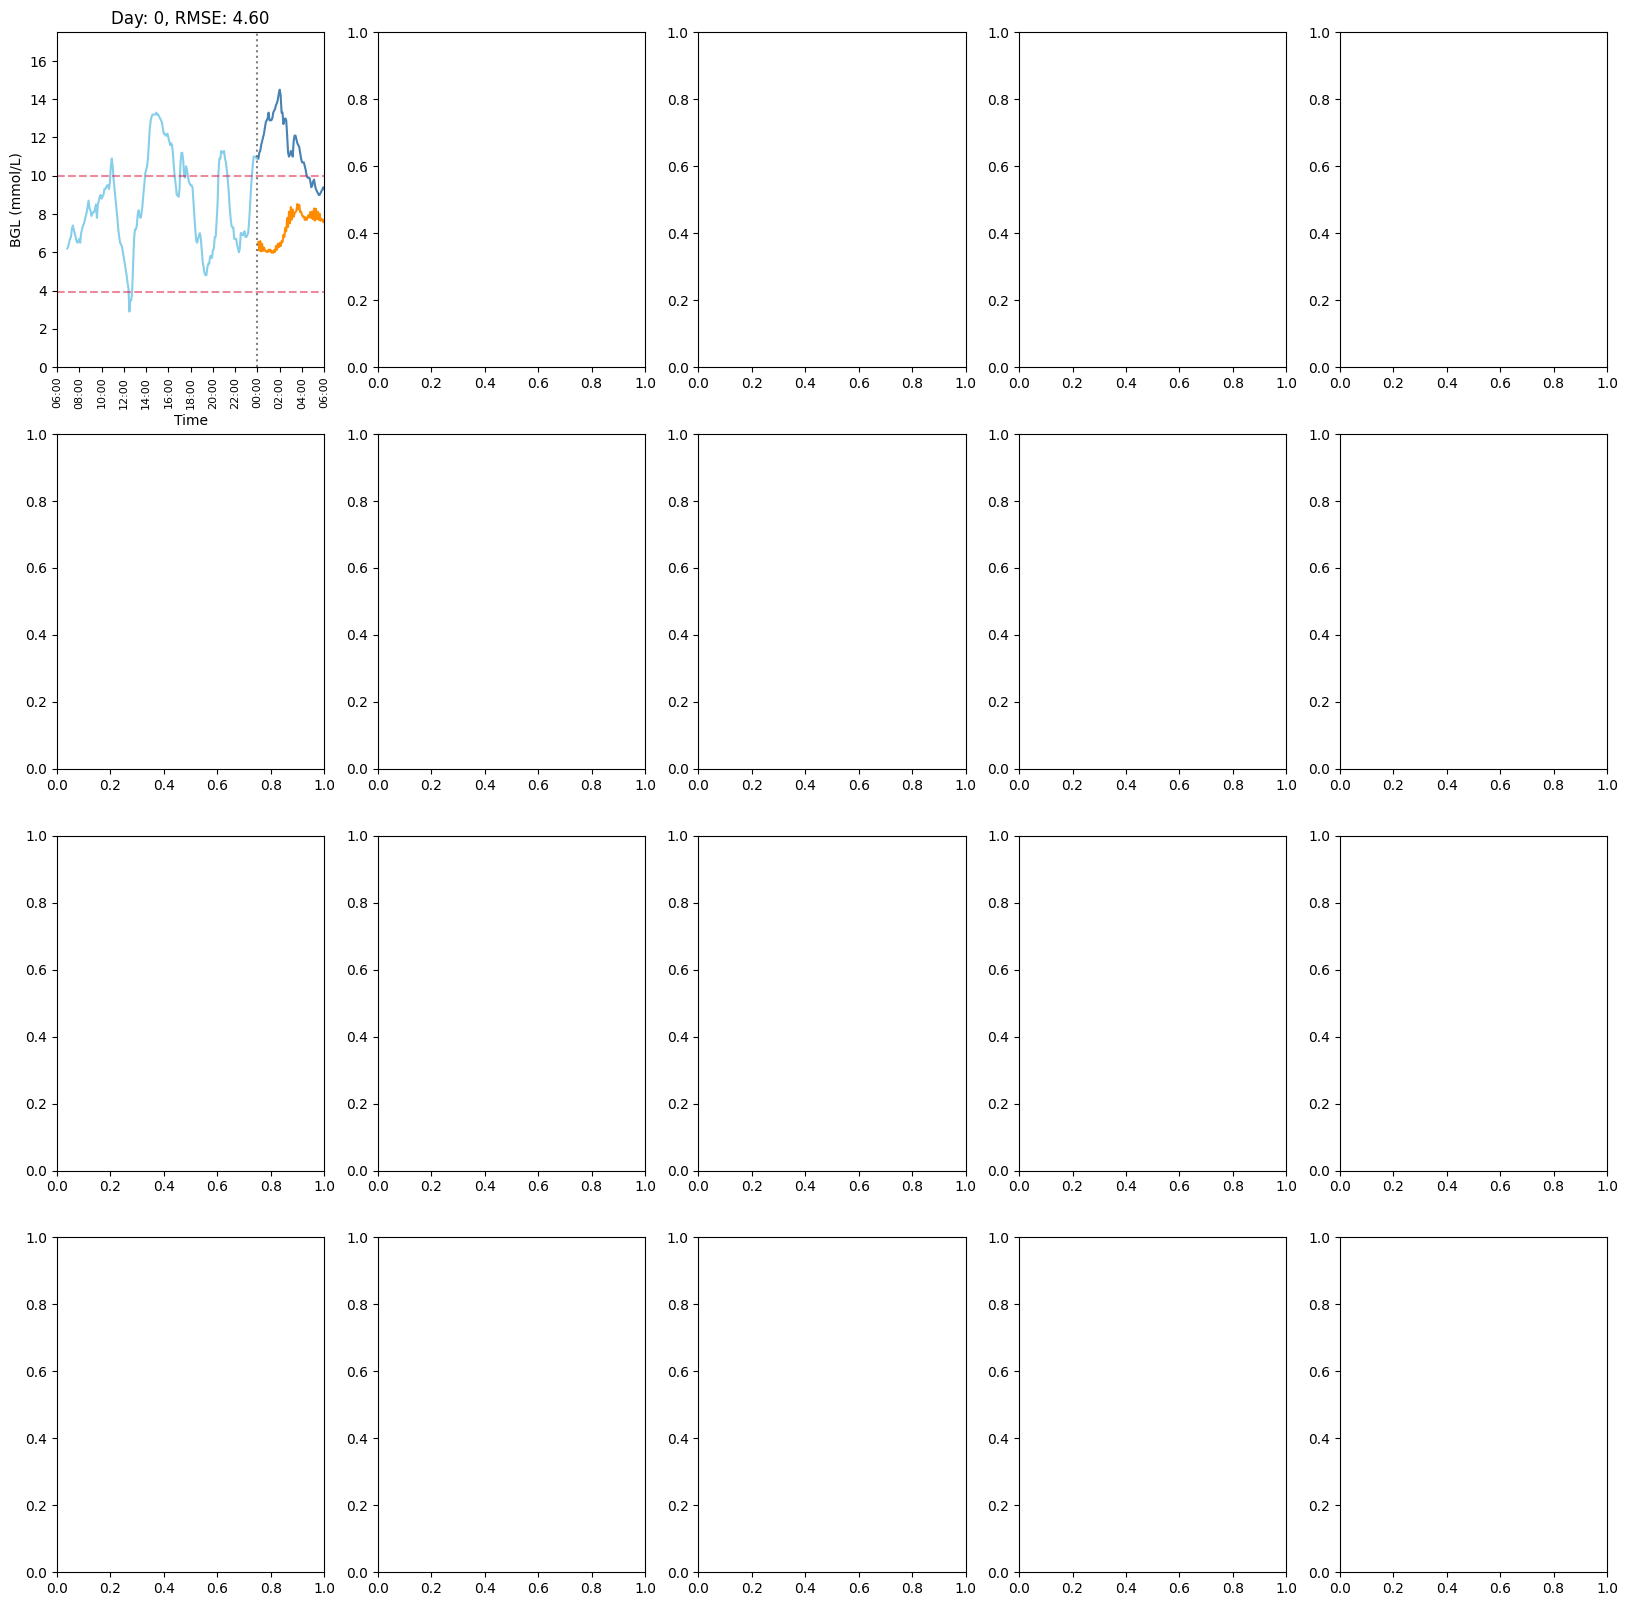

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create time index once (288 steps of 5 minutes from 6AM to 6AM next day)
time_index = pd.date_range(
    start="2024-01-01 06:00:00", end="2024-01-02 06:00:00", periods=289
)

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Initialize the subplot counter
subplot_idx = 0
RMS_ERRORS = np.array([])
ERRORS_NIGHT = np.array([])

# Store lines for legend
legend_lines = []
legend_labels = []

# Loop over each day split and create one plot per day
for _, train_period, test_period in loader.get_validation_day_splits(patient):
    y_day, X_day = reduce_features(train_period)
    y_night, X_night = reduce_features(test_period)

    activity_categories = (
        pd.concat([train_period["activity-0:00"], test_period["activity-0:00"]])
        .fillna("Unknown")
        .astype("category")
    )
    X_day["activity-0:00"] = activity_categories.cat.codes.iloc[: len(X_day)].values
    X_night["activity-0:00"] = activity_categories.cat.codes.iloc[len(X_day) :].values

    if X_day.isna().sum().any() > 0:
        print(X_day)
    if X_night.isna().sum().any() > 0:
        print(X_night)

    # Update the model with the true glucose levels for the day
    forecaster.update(y=y_day, X=X_day, update_params=False)

    ######## Determine MSE between predicted and true glucose levels ########
    predicted_bg = forecaster.predict(fh=fh, X=X_day)

    ######## Plot true glucose levels ########
    ax = axes[subplot_idx]
    daystart = 216 - len(y_day)
    day_line = ax.plot(
        time_index[daystart : len(y_day) + daystart],
        y_day["bg-0:00"],
        color="skyblue",
        label="True glucose levels",
    )[0]
    night_line = ax.plot(
        time_index[-72:],
        y_night["bg-0:00"],
        color="steelblue",
        linestyle="-",
        label="True nocturnal glucose levels",
    )[0]

    predicted_bg_ax = ax.plot(
        time_index[-72:],
        predicted_bg,
        color="darkorange",
        linestyle="-",
        label="Predicted glucose levels",
    )[0]

    # Format x-axis
    ax.xaxis.set_major_locator(
        mdates.HourLocator(interval=2)
    )  # Show ticks every 2 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM

    mse = np.sqrt(np.mean((predicted_bg.values - y_night["bg-0:00"].values) ** 2))
    SE_NIGHT = (predicted_bg.values - y_night["bg-0:00"].values) ** 2
    ERRORS_NIGHT = np.append(ERRORS_NIGHT, SE_NIGHT)
    RMS_ERRORS = np.append(RMS_ERRORS, mse)
    ax.set_title(f"Day: {subplot_idx}, RMSE: {mse:.2f}")

    ######## Plot predicted glucose levels ########
    # Only store legend items from first subplot
    if subplot_idx == 0:
        legend_lines.extend([day_line, night_line, predicted_bg_ax])
        legend_labels.extend(
            [
                "True glucose levels",
                "True nocturnal glucose levels",
                "Predicted glucose levels",
            ]
        )

    # Set limits to show full 24-hour period
    ax.set_xlim(time_index[0], time_index[-1])

    # Add labels and formatting for each subplot (remove legend)
    ax.set_xlabel("Time", fontsize=10)
    # Hide y-axis labels for all plots except first in each row
    if subplot_idx % 5 != 0:  # If not first plot in row
        ax.yaxis.set_ticklabels([])
    else:
        ax.set_ylabel("BGL (mmol/L)", fontsize=10)
    ax.set_ylim(0, 17.5)

    ax.tick_params(axis="x", rotation=90, labelsize=8)
    # Add horizontal reference lines
    ax.axhline(
        y=3.9, color="crimson", linestyle="--", alpha=0.5
    )  # Hypoglycemia threshold
    ax.axhline(
        y=10.0, color="crimson", linestyle="--", alpha=0.5
    )  # Hyperglycemia threshold
    ax.axvline(
        x=time_index[216], color="black", linestyle=":", alpha=0.5
    )  # Nocturnal start
    # Update the model with the true glucose levels for the night
    # forecaster.update(y=y_night, X=X_night, update_params=False)

    # Increment the subplot index for the next day
    subplot_idx += 1

TOTAL_TEST_RMSE = np.sqrt(np.mean(ERRORS_NIGHT))

model = "RandomForestRegressor"
fig.suptitle(
    f"Point Forecasting of Nocturnal Glucose Levels \n {model} (1000 epochs), Overall Nocturnal RMSE: {TOTAL_TEST_RMSE:.2f}",
    fontweight="bold",
    fontsize=16,
)

# Add a single legend outside the subplots
fig.legend(legend_lines, legend_labels, ncols=3, bbox_to_anchor=(0.65, 0.0))

# Adjust layout to avoid overlap with the legend
plt.tight_layout(rect=[0, 0, 0.95, 1], pad=2.0)

# Show the figure with multiple subplots
plt.show()


print(RMS_ERRORS.mean())